## Applying to new dataset

In [1]:
import pandas as pd
df=pd.read_csv("./labeled_banners.csv")

In [9]:
import numpy as np
from PIL import Image, ImageOps
import random
import math
import json
from torchvision import transforms


def load_image(image_path):
    return Image.open('./SOD_inputs_EU/'+image_path+'.png')

def apply_transformations(image, boxes, max_shift=15):
    original_width, original_height = image.size


    shift_x = random.randint(-max_shift, max_shift)
    #print(shift_x)
    shift_y = random.randint(-max_shift, max_shift)
    #print(shift_y)
  
    flip_vertical = random.choice([True, False])
    flip_horizontal = random.choice([True, False])
    #Can flip on these three following lines to enforce noise as a test
    #flip_vertical=True
    #flip_horizontal=True
    #do_shift=True
    do_shift=random.choice([True, False])
    if do_shift:
        image = ImageOps.expand(image, border=(max_shift, max_shift, max_shift, max_shift), fill=0)
        image = image.transform(image.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))


    if flip_vertical:
        image = ImageOps.flip(image)
    if flip_horizontal:
        image = ImageOps.mirror(image)
        
        
    ## change p for probability of applying 
    transform_color=transforms.RandomApply([transforms.ColorJitter(brightness=0.02, contrast=0.02, saturation=0.02, hue=0.02)], p=0.5)
    
    transform_blur=transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.02))], p=0.5)
    image=transform_color(image)
    image=transform_blur(image)
    new_boxes = []
    ##This updates the bounding boxes based on any transformations made
    for box in boxes:
        x = box['x'] / 100 * original_width
        y = box['y'] / 100 * original_height
        w = box['width'] / 100 * original_width
        h = box['height'] / 100 * original_height

        if do_shift:
            x += -shift_x + max_shift
            y += -shift_y + max_shift

        if flip_vertical:
            y = image.height - y - h
        if flip_horizontal:
            x = image.width - x - w

        new_boxes.append({
            'x': x / image.width * 100,
            'y': y / image.height * 100,
            'width': w / image.width * 100,
            'height': h / image.height * 100,
            'rectanglelabels': box['rectanglelabels'],
            'original_height':image.height,
            'original_width':image.width
        })

    return image, new_boxes


image_path = 'fontawesome.com'
bbox_json = df.label[0]
boxes = json.loads(bbox_json)

image = load_image(image_path)
transformed_image, transformed_boxes = apply_transformations(image, boxes)

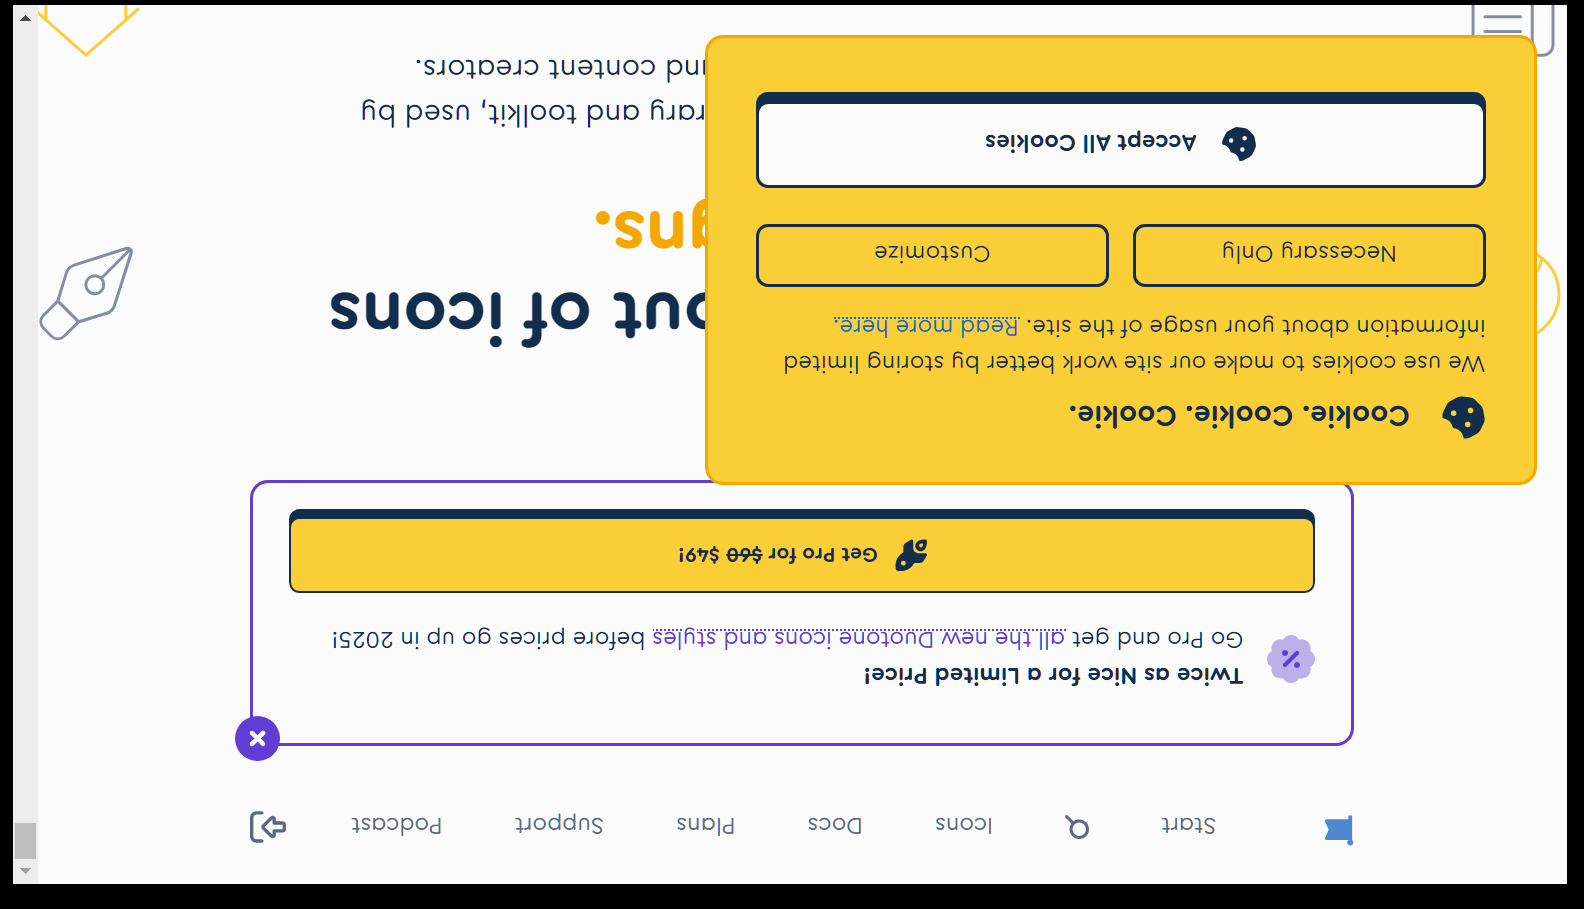

In [10]:
transformed_image

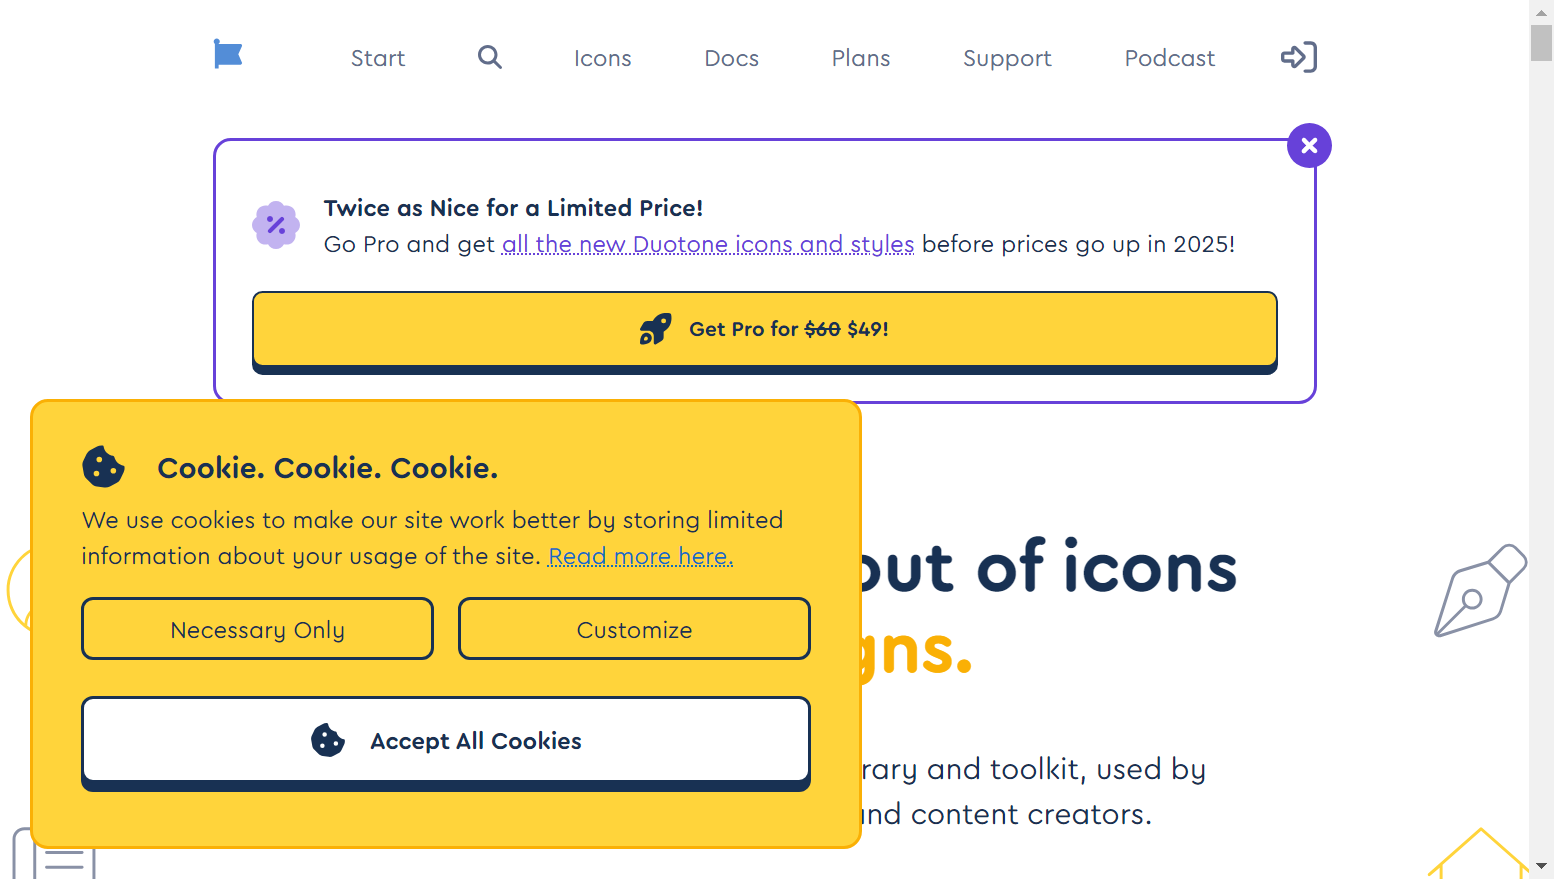

In [11]:
image

In [2]:
##Only applying to the compliant options with all 3 buttons
df_subset=df[(df.Final_label=='full')|(df.Final_label=='full choices')|(df.Final_label=='x')]
df_subset=df_subset.reset_index()

In [17]:
def load_image(image_path,euip):
    if euip==True:
        return Image.open('./SOD_inputs_EU/'+image_path+'.png')
    if euip==False:
        return Image.open('./SOD_inputs_NY/'+image_path+'.png')

In [ ]:
data=[]
import numpy as np
from PIL import Image, ImageOps
import random
import math
import json
from torchvision import transforms
for idx, row in df_subset.iterrows():
    if row['EUIP']==True:
        path='./SOD_inputs_EU/'+row['shortened_url']+'.png'
    if row['EUIP']==False:
        path='./SOD_inputs_NY/'+row['shortened_url']+'.png'
    with Image.open(path) as image:
        print(row['shortened_url'])
        bbox_json = row['label']
        boxes = json.loads(bbox_json)
        # get 32 images with randomly inserted noises 
        for i in range(32):
            d={}
            transformed_image, transformed_boxes = apply_transformations(image, boxes)
            ##Must create folder to save the noisy images so they can be input to SOD model
            transformed_image.save(f'.SOD_noisy_inputs/{row["shortened_url"]}_{row["EUIP"]}_{i}.png')
            d['id']=f'{row["shortened_url"]}_{row["EUIP"]}_{i}'
            d['box']=transformed_boxes
            d['EUIP']=row['EUIP']
            d['EU']=row['EU']
            data.append(d)
        

In [ ]:
##Need to save the transformed positions of bounding boxes to avoid relabeling. 
df_noise=pd.DataFrame(data)
df_noise.to_csv("./noisy_bounding_boxes.csv")

In [3]:
## After putting noisy images through SOD model, can aggregate their salience scores.
import pandas as pd
df_noise=pd.read_csv("./noisy_bounding_boxes.csv")
df_noise['domain'] = df_noise['id'].str.extract(r'(^.+?)(?=_\d+$)')
len(df_noise)

28608

In [4]:
from PIL import Image
import numpy as np
import json
import ast
df_noise['x_salience_avg']=0
df_noise['accept_salience_avg']=0
df_noise['reject_salience_avg']=0
df_noise['manage_salience_avg']=0
df_noise['banner_salience_avg']=0
df_noise['x_salience_max']=0
df_noise['accept_salience_max']=0
df_noise['reject_salience_max']=0
df_noise['manage_salience_max']=0
df_noise['banner_salience_max']=0
for i in range(len(df_noise)):
    if i%100==0:
        print(i)
    json_string=df_noise['box'][i]
    json_list=ast.literal_eval(json_string)
    #data = json.loads(json_string)
    domain=df_noise.id[i]
    image = Image.open(f"C:/Users/riley/deeprare2019/SOD_outputs_DRnoise/{domain}.jpg")
    image_array = np.array(image)
    for j in json_list:
        t=j['rectanglelabels'][0]
        x=j['x']
        y=j['y']
        height=j['height']
        width=j['width']
        original_height=j['original_height']
        original_width=j['original_width']
        avg_salience=(image_array[int(y/100*original_height):int((y+height)/100*original_height),int(x/100*original_width):int((x+width)/100*original_width)].mean())
        df_noise.at[i,f'{t}_salience_avg']=avg_salience
        max_salience=(image_array[int(y/100*original_height):int((y+height)/100*original_height),int(x/100*original_width):int((x+width)/100*original_width)].max())
        df_noise.at[i,f'{t}_salience_max']=max_salience
    image.close()

0


C:\Users\riley\AppData\Local\Temp\ipykernel_51084\3942897601.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '119.17008698015765' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_noise.at[i,f'{t}_salience_avg']=avg_salience
C:\Users\riley\AppData\Local\Temp\ipykernel_51084\3942897601.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '114.23792' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_noise.at[i,f'{t}_salience_avg']=avg_salience
C:\Users\riley\AppData\Local\Temp\ipykernel_51084\3942897601.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '178.1605861244019' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_noise.at[i,f'{t}_salience_

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [6]:
## Now you can save this as robust_salience_scores.csv
df_noise.to_csv("robust_salience_scores.csv")

## Replicating results in paper 

In [ ]:
## Load in the robust salience scores from noisy images input to SOD model
import pandas as pd
df_noise=pd.read_csv('./robust_salience_scores.csv')

In [7]:
df_noise.describe()

,Unnamed: 0,x_salience_avg,accept_salience_avg,reject_salience_avg,manage_salience_avg,banner_salience_avg,x_salience_max,accept_salience_max,reject_salience_max,manage_salience_max,banner_salience_max
count,28608.000000,28608.0,28608.000000,28608.000000,28608.000000,28608.000000,28608.0,28608.000000,28608.000000,28608.000000,28608.000000
mean,7230.569351,0.0,146.140558,121.709317,100.464844,81.184174,0.0,217.706690,195.301699,176.431173,238.634613
std,4263.303800,0.0,40.466453,44.865038,34.210110,18.562686,0.0,40.908708,48.275700,46.965854,27.565753
min,0.000000,0.0,15.056747,6.385694,9.238566,26.060500,0.0,49.000000,21.000000,33.000000,94.000000
25%,3575.750000,0.0,119.712581,89.069490,78.197602,68.733349,0.0,193.000000,161.000000,141.000000,228.000000
50%,7151.500000,0.0,150.997915,118.308916,97.241966,79.361373,0.0,231.000000,200.000000,177.000000,255.000000
75%,10727.250000,0.0,179.141787,159.168324,119.915576,93.577153,0.0,254.000000,241.000000,211.000000,255.000000
max,15807.000000,0.0,232.371303,229.878792,221.134569,171.877378,0.0,255.000000,255.000000,255.000000,255.000000


In [8]:
##min max scaling and summing the normalized max and avg salience scores for each button
accept_avg_min=df_noise[df_noise.accept_salience_max!=0]['accept_salience_avg'].min()
accept_avg_max=df_noise.accept_salience_avg.max()
manage_avg_min=df_noise[df_noise.manage_salience_max!=0]['manage_salience_avg'].min()
manage_avg_max=df_noise.manage_salience_avg.max()
reject_avg_min=df_noise[df_noise.reject_salience_max!=0]['reject_salience_avg'].min()
reject_avg_max=df_noise.reject_salience_avg.max()
x_avg_min=df_noise[df_noise.x_salience_max!=0]['x_salience_avg'].min()
x_avg_max=df_noise.x_salience_avg.max()

df_avg_min=min(accept_avg_min,manage_avg_min,reject_avg_min,x_avg_min)
print(df_avg_min)
df_avg_max=max(accept_avg_max,manage_avg_max,reject_avg_max,x_avg_max)
print(df_avg_max)

accept_max_min=df_noise[df_noise.accept_salience_max!=0]['accept_salience_max'].min()
accept_max_max=df_noise.accept_salience_max.max()
manage_max_min=df_noise[df_noise.manage_salience_max!=0]['manage_salience_max'].min()
manage_max_max=df_noise.manage_salience_max.max()
reject_max_min=df_noise[df_noise.reject_salience_max!=0]['reject_salience_max'].min()
reject_max_max=df_noise.reject_salience_max.max()
x_max_min=df_noise[df_noise.x_salience_max!=0]['x_salience_max'].min()
x_max_max=df_noise.x_salience_max.max()

df_max_min=min(accept_max_min,manage_max_min,reject_max_min,x_max_min)
print(df_max_min)
df_max_max=max(accept_max_max,manage_max_max,reject_max_max,x_max_max)
print(df_max_max)


df_noise['accept_salience']=((df_noise['accept_salience_avg']-df_avg_min)/(df_avg_max-df_avg_min))+((df_noise['accept_salience_max']-df_max_min)/(df_max_max-df_max_min))
df_noise['reject_salience']=((df_noise['reject_salience_avg']-df_avg_min)/(df_avg_max-df_avg_min))+((df_noise['reject_salience_max']-df_max_min)/(df_max_max-df_max_min))
df_noise['manage_salience']=((df_noise['manage_salience_avg']-df_avg_min)/(df_avg_max-df_avg_min))+((df_noise['manage_salience_max']-df_max_min)/(df_max_max-df_max_min))
df_noise['x_salience']=((df_noise['x_salience_avg']-df_avg_min)/(df_avg_max-df_avg_min))+((df_noise['x_salience_max']-df_max_min)/(df_max_max-df_max_min))

6.3856936714079575
232.37130254281266
21
255


In [10]:
cols_to_aggregate = df_noise.columns[6:]

# Now group and aggregate
grouped_stats = df_noise.groupby('domain')[cols_to_aggregate].agg(['mean', 'std'])
# Now group by domain and compute mean and std
cats = df_noise.groupby('domain')[['EU', 'EUIP']].first()

# Now join it with your grouped_stats
grouped_stats = grouped_stats.reset_index()
cats = cats.reset_index()
grouped_stats

domain x_salience_avg      accept_salience_avg            \
                                  mean  std                mean       std   
0        01net.com_True            0.0  0.0           95.033675  7.754132   
1    20minutes.fr_False            0.0  0.0          207.237705  6.342999   
2     20minutes.fr_True            0.0  0.0          203.235696  4.956675   
3         7sun.eu_False            0.0  0.0          166.686802  8.125105   
4          7sun.eu_True            0.0  0.0          166.711356  8.965289   
..                  ...            ...  ...                 ...       ...   
889  zoopla.co.uk_False            0.0  0.0          191.966405  4.281804   
890   zoopla.co.uk_True            0.0  0.0          178.537423  3.792949   
891      zoznam.sk_True            0.0  0.0          173.002277  6.596787   
892   zwoenitz.de_False            0.0  0.0          135.785039  5.278434   
893    zwoenitz.de_True            0.0  0.0          139.820135  4.902753   

    reject_salience_avg            manage_salience_avg             \
                   mean        std                mean        std   
0             80.921522   6.346073           60.203617   6.649734   
1            160.891950  10.948699          156.701889  13.182233   
2            120.793627  14.706918          146.004782  12.193061   
3            125.545344   5.191694          120.122708   6.688629   
4            121.900662   8.077791          122.214823   7.111207   
..                  ...        ...                 ...        ...   
889          181.360868   8.679626          127.377396   7.621381   
890          108.661220   5.840532           87.971952   5.440719   
891           35.632426   8.231854           44.886672   5.548816   
892          137.437847   5.822306          101.046332   5.510686   
893          137.217548   4.852749          111.363352   6.080560   

    banner_salience_avg  ... banner_salience_max           accept_salience  \
                   mean  ...                mean       std            mean   
0             64.639048  ...           254.93750  0.245935        1.392006   
1            105.554590  ...           255.00000  0.000000        1.885444   
2            104.072201  ...           255.00000  0.000000        1.867334   
3            107.298630  ...           254.87500  0.707107        1.530256   
4            105.932056  ...           255.00000  0.000000        1.516609   
..                  ...  ...                 ...       ...             ...   
889          108.465667  ...           255.00000  0.000000        1.821072   
890           97.390213  ...           255.00000  0.000000        1.761515   
891           62.924383  ...           255.00000  0.000000        1.641001   
892          108.127413  ...           255.00000  0.000000        1.410073   
893          113.605413  ...           254.53125  0.915260        1.436876   

              reject_salience           manage_salience           x_salience  \
          std            mean       std            mean       std       mean   
0    0.034486        0.811396  0.068408        1.191540  0.043212  -0.118001   
1    0.037080        1.521841  0.114362        1.497156  0.147696  -0.118001   
2    0.023497        1.193762  0.154770        1.395200  0.136374  -0.118001   
3    0.081628        1.251648  0.059650        1.182246  0.064205  -0.118001   
4    0.089881        1.275050  0.083899        1.229164  0.068790  -0.118001   
..        ...             ...       ...             ...       ...        ...   
889  0.019132        1.681594  0.074316        1.307030  0.086391  -0.118001   
890  0.017602        1.288713  0.072747        0.949032  0.061318  -0.118001   
891  0.069190        0.324397  0.090835        0.412089  0.051669  -0.118001   
892  0.059409        1.382531  0.063934        0.985786  0.073890  -0.118001   
893  0.052638        1.374478  0.065234        1.072438  0.089870  -0.118001   

          
     std  
0    0.0  
1    0.0  
2    0.0  
3    0

In [11]:
##Overall prevalence of aesthetic manipulation -- threshold values between 2-7%

print('accept %s')
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.02*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.02*grouped_stats.reject_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.03*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.03*grouped_stats.reject_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.04*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.04*grouped_stats.reject_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.05*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.05*grouped_stats.reject_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.06*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.06*grouped_stats.reject_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.07*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.07*grouped_stats.reject_salience['mean'])])/len(grouped_stats))

print('reject %s')
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.02*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.02*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.03*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.03*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.04*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.04*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.05*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.05*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.06*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.06*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.07*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.07*grouped_stats.accept_salience['mean'])])/len(grouped_stats))

print('manage %s')

print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.02*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.02*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.03*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.03*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.04*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.04*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.05*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.05*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.06*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.06*grouped_stats.accept_salience['mean'])])/len(grouped_stats))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.07*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.07*grouped_stats.accept_salience['mean'])])/len(grouped_stats))

accept %s
0.4809843400447427
0.4451901565995526
0.4228187919463087
0.3970917225950783
0.3870246085011186
0.38031319910514544
reject %s
0.1767337807606264
0.14988814317673377
0.12639821029082773
0.10738255033557047
0.0883668903803132
0.07606263982102908
manage %s
0.1040268456375839
0.0883668903803132
0.07941834451901567
0.07270693512304251
0.06823266219239374
0.06152125279642058


In [13]:
cats

,domain,EU,EUIP
0,01net.com_True,False,True
1,20minutes.fr_False,True,False
2,20minutes.fr_True,True,True
3,7sun.eu_False,True,False
4,7sun.eu_True,True,True
...,...,...,...
889,zoopla.co.uk_False,True,False
890,zoopla.co.uk_True,True,True
891,zoznam.sk_True,True,True
892,zwoenitz.de_False,True,False


In [10]:
## 7% threshold results presented in Table 4 of paper. 

## By location - threshold values between 2-7%

#to get category change location, change cats statements 
# EU websites - (cats.EU==True)
#EU IP - (cats.EUIP==True)
# non-EU websites - (cats.EU==False)
#NY IP - (cats.EUIP==False)
# EU websites, EU IP - (cats.EU==True)&(cats.EUIP==True)
#non-EU websites, EU IP - (cats.EU==False)&(cats.EUIP==True)
# EU websites, NY IP - (cats.EU==True)&(cats.EUIP==False)
#non-EU websites, NY IP - (cats.EU==False)&(cats.EUIP==False)


print('accept %s')
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.02*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.02*grouped_stats.reject_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.03*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.03*grouped_stats.reject_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.04*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.04*grouped_stats.reject_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.05*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.05*grouped_stats.reject_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.06*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.06*grouped_stats.reject_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.accept_salience['mean']>=1.07*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=1.07*grouped_stats.reject_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))

print('reject %s')
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.02*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.02*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.03*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.03*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.04*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.04*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.05*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.05*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.06*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.06*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.reject_salience['mean']>=1.07*grouped_stats.manage_salience['mean'])&(grouped_stats.reject_salience['mean']>=1.07*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))

print('manage %s')

print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.02*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.02*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.03*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.03*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.04*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.04*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.05*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.05*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.06*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.06*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))
print(len(grouped_stats[(grouped_stats.manage_salience['mean']>=1.07*grouped_stats.reject_salience['mean'])&(grouped_stats.manage_salience['mean']>=1.07*grouped_stats.accept_salience['mean'])&(cats.EU==True)])/len(grouped_stats[(cats.EU==True)]))

accept %s
0.5204582651391162
0.4909983633387889
0.46481178396072015
0.4451718494271686
0.4337152209492635
0.4238952536824877
reject %s
0.14893617021276595
0.132569558101473
0.10638297872340426
0.09328968903436989
0.08183306055646482
0.07201309328968904
manage %s
0.09492635024549918
0.07528641571194762
0.07037643207855974
0.06382978723404255
0.060556464811783964
0.05237315875613748


In [11]:
len(cats[(cats.EU==False)&(cats.EUIP==False)]),len(cats[(cats.EU==True)&(cats.EUIP==False)]),len(cats[(cats.EU==False)&(cats.EUIP==True)]),len(cats[(cats.EU==True)&(cats.EUIP==True)])

(35, 268, 248, 343)

In [14]:
len(cats[cats.EUIP==False]),len(cats[cats.EUIP==True])

(303, 591)

In [20]:
## For regression results presented in Table 5

temp_data=pd.DataFrame({
    'domain':grouped_stats.domain,
    'accept_salience_mean': grouped_stats['accept_salience']['mean'],
    'reject_salience_mean': grouped_stats['reject_salience']['mean'],
    'manage_salience_mean': grouped_stats['manage_salience']['mean'],
    'EU':cats.EU,
    'EUIP':cats.EUIP
})
temp_data

,domain,accept_salience_mean,reject_salience_mean,manage_salience_mean,EU,EUIP
0,01net.com_True,1.392006,0.811396,1.191540,False,True
1,20minutes.fr_False,1.885444,1.521841,1.497156,True,False
2,20minutes.fr_True,1.867334,1.193762,1.395200,True,True
3,7sun.eu_False,1.530256,1.251648,1.182246,True,False
4,7sun.eu_True,1.516609,1.275050,1.229164,True,True
...,...,...,...,...,...,...
889,zoopla.co.uk_False,1.821072,1.681594,1.307030,True,False
890,zoopla.co.uk_True,1.761515,1.288713,0.949032,True,True
891,zoznam.sk_True,1.641001,0.324397,0.412089,True,True
892,zwoenitz.de_False,1.410073,1.382531,0.985786,True,False


In [21]:
## repeated measure Anova (use GG-corr if sphericity=False)
import pingouin as pg
long_data = pd.melt(temp_data, id_vars=['domain','EUIP','EU'], value_vars=['accept_salience_mean', 'reject_salience_mean', 'manage_salience_mean'],
                    var_name='condition', value_name='score')
res=pg.rm_anova(data=long_data,dv='score',within='condition',subject='domain')
res

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,condition,2,1786,474.509284,5.304075e-166,3.820993e-163,0.167268,0.982419,False,0.982104,0.000318


In [22]:
# shows the differences between each button types salience scores is not normal
diff_ab = temp_data['accept_salience_mean'] - temp_data['reject_salience_mean']
diff_ac = temp_data['reject_salience_mean'] - temp_data['manage_salience_mean']
diff_bc = temp_data['manage_salience_mean'] - temp_data['accept_salience_mean']

pd.concat([pg.normality(diff_ab),pg.normality(diff_ac),pg.normality(diff_bc)],axis=0)

,W,pval,normal
0,0.883042,2.085637e-25,False
0,0.983883,2.318287e-08,False
0,0.990372,1.365773e-05,False


In [23]:
## Wilcoxen signed rank test because not normal
posthoc_nonparametric = pg.pairwise_tests(
    dv='score', within='condition', subject='domain', 
    data=long_data, parametric=False, padjust='bonferroni'
)
posthoc_nonparametric

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,condition,accept_salience_mean,manage_salience_mean,True,False,29313.0,two-sided,2.792861e-108,8.378584e-108,bonferroni,1.164106
1,condition,accept_salience_mean,reject_salience_mean,True,False,89371.0,two-sided,1.442584e-46,4.327752e-46,bonferroni,0.569345
2,condition,manage_salience_mean,reject_salience_mean,True,False,107894.0,two-sided,8.207063e-33,2.462119e-32,bonferroni,-0.495759


In [24]:
long_data

,domain,EUIP,EU,condition,score
0,01net.com_True,True,False,accept_salience_mean,1.392006
1,20minutes.fr_False,False,True,accept_salience_mean,1.885444
2,20minutes.fr_True,True,True,accept_salience_mean,1.867334
3,7sun.eu_False,False,True,accept_salience_mean,1.530256
4,7sun.eu_True,True,True,accept_salience_mean,1.516609
...,...,...,...,...,...
2677,zoopla.co.uk_False,False,True,manage_salience_mean,1.307030
2678,zoopla.co.uk_True,True,True,manage_salience_mean,0.949032
2679,zoznam.sk_True,True,True,manage_salience_mean,0.412089
2680,zwoenitz.de_False,False,True,manage_salience_mean,0.985786


In [25]:
## Regression results in Table 5 of paper

import statsmodels.formula.api as smf
##Very little change when adding website fixed effects, but being in EU no longer significant and manage buttons have lower
## salience when visited by EU IP than NY IP. Not sure why this last part occurs (barely significant)

formula = "score ~ C(condition) * EUIP * EU + C(domain)"
model = smf.ols(formula, data=long_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     4.470
Date:                Fri, 01 Aug 2025   Prob (F-statistic):          1.28e-159
Time:                        15:40:33   Log-Likelihood:                 388.05
No. Observations:                2682   AIC:                             1028.
Df Residuals:                    1780   BIC:                             6345.
Df Model:                         901                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [10]:
## Creating Fig 9 
nums1=[]
for i in np.arange(1,1.10,0.01):
    nums1.append(len(grouped_stats[(grouped_stats.accept_salience['mean']>=i*grouped_stats.manage_salience['mean'])&(grouped_stats.accept_salience['mean']>=i*grouped_stats.reject_salience['mean'])])/len(grouped_stats))

0.4809843400447427
0.4451901565995526
0.4228187919463087
0.3970917225950783
0.3870246085011186
0.38031319910514544
1.0
1.01
1.02
1.03
1.04
1.05
1.06
1.07
1.08
1.09
1.1


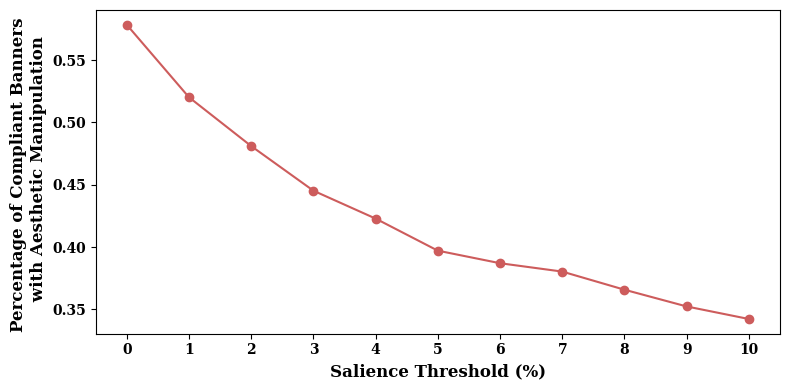

In [13]:
## Fig 9 appendix showing aesthetic manipulation prevalence as function of chosen threshold

import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
plt.plot(nums1, marker='o', linestyle='-', color='indianred', label='Line Plot')

plt.xlabel('Salience Threshold (%)', fontsize=12, fontdict={'family': 'serif', 'weight': 'semibold'})
plt.ylabel('Percentage of Compliant Banners \n with Aesthetic Manipulation', fontsize=12, fontdict={'family': 'serif', 'weight': 'semibold'})
custom_x_ticks = np.arange(0,11,1) 


plt.xticks(ticks=range(len(nums1)), labels=custom_x_ticks,fontsize=10, fontfamily='serif', weight='semibold')
plt.yticks(fontsize=10, fontfamily='serif', weight='semibold')
plt.grid(True, linestyle='', alpha=0.7)
plt.tight_layout()
plt.savefig('threshold_new.pdf', format='pdf', dpi=1200)
plt.show()


In [17]:
nums1

[0.5782997762863534,
 0.5201342281879194,
 0.4809843400447427,
 0.4451901565995526,
 0.4228187919463087,
 0.3970917225950783,
 0.3870246085011186,
 0.38031319910514544,
 0.36577181208053694,
 0.3523489932885906,
 0.3422818791946309]

## Alternate Results

In [16]:
df_noise['gap_a-r']=df_noise['accept_salience']-df_noise['reject_salience']
df_noise['gap_a-m']=df_noise['accept_salience']-df_noise['manage_salience']
df_noise['gap_m-r']=df_noise['manage_salience']-df_noise['reject_salience']
from collections import Counter
cols_to_aggregate = df_noise.columns[-3:]

# Now group and aggregate
grouped_stats2 = df_noise.groupby('domain')[cols_to_aggregate].agg(lambda x: (x < 0).sum())
# Now group by domain and compute mean and std

grouped_stats2


##All 32 noisy images has button as most salient -- rather than looking at gap in mean scores
print(len(grouped_stats2[(grouped_stats2['gap_a-r']==0)&(grouped_stats2['gap_a-m']==0)])/len(grouped_stats2))
print(len(grouped_stats2[(grouped_stats2['gap_a-r']==32)&(grouped_stats2['gap_m-r']==32)])/len(grouped_stats2))
print(len(grouped_stats2[(grouped_stats2['gap_a-m']==32)&(grouped_stats2['gap_m-r']==0)])/len(grouped_stats2))

,gap_a-r,gap_a-m,gap_m-r
domain,,,
01net.com_True,0,0,0
20minutes.fr_False,0,0,21
20minutes.fr_True,0,0,6
7sun.eu_False,0,0,25
7sun.eu_True,0,0,23
...,...,...,...
zoopla.co.uk_False,0,0,32
zoopla.co.uk_True,0,0,32
zoznam.sk_True,0,0,3
